In [1]:
import sys
sys.path.insert(0, '../')

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Markdown, display

# Datasets
from aif360.datasets import MEPSDataset19
from aif360.datasets import MEPSDataset20
from aif360.datasets import MEPSDataset21
from aif360.datasets import AdultDataset
# Fairness metrics
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric

# Explainers
from aif360.explainers import MetricTextExplainer
# Scalers
from sklearn.preprocessing import StandardScaler

# Classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

# Bias mitigation techniques
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import PrejudiceRemover

# LIME
from aif360.datasets.lime_encoder import LimeEncoder
import lime
from lime.lime_tabular import LimeTabularExplainer

import numpy as np
from IPython.display import Markdown, display
from aif360.datasets import AdultDataset
from aif360.metrics import ClassificationMetric
from tensorflow.keras import Sequential
from tensorflow.keras.layers import InputLayer, Dropout, Dense
from noisylabeltk.metrics import Accuracy
from aif360.algorithms import Transformer
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K

np.random.seed(1)

In [2]:

(dataset_train,
 dataset_val,
 dataset_test) = MEPSDataset19().split([0.5, 0.8], shuffle=True)

sens_ind = 0
sens_attr = dataset_train.protected_attribute_names[sens_ind]

unprivileged_groups = [{sens_attr: v} for v in
                       dataset_train.unprivileged_protected_attributes[sens_ind]]
privileged_groups = [{sens_attr: v} for v in
                     dataset_train.privileged_protected_attributes[sens_ind]]

In [3]:
def describe(train=None, val=None, test=None):
    if train is not None:
        display(Markdown("#### Training Dataset shape"))
        print(train.features.shape)
    if val is not None:
        display(Markdown("#### Validation Dataset shape"))
        print(val.features.shape)
    display(Markdown("#### Test Dataset shape"))
    print(test.features.shape)
    display(Markdown("#### Favorable and unfavorable labels"))
    print(test.favorable_label, test.unfavorable_label)
    display(Markdown("#### Protected attribute names"))
    print(test.protected_attribute_names)
    display(Markdown("#### Privileged and unprivileged protected attribute values"))
    print(test.privileged_protected_attributes,
          test.unprivileged_protected_attributes)
    display(Markdown("#### Dataset feature names"))
    print(test.feature_names)

In [4]:
describe(dataset_train, dataset_val, dataset_test)

#### Training Dataset shape

(7915, 138)


#### Validation Dataset shape

(4749, 138)


#### Test Dataset shape

(3166, 138)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['RACE']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names

['AGE', 'RACE', 'PCS42', 'MCS42', 'K6SUM42', 'REGION=1', 'REGION=2', 'REGION=3', 'REGION=4', 'SEX=1', 'SEX=2', 'MARRY=1', 'MARRY=2', 'MARRY=3', 'MARRY=4', 'MARRY=5', 'MARRY=6', 'MARRY=7', 'MARRY=8', 'MARRY=9', 'MARRY=10', 'FTSTU=-1', 'FTSTU=1', 'FTSTU=2', 'FTSTU=3', 'ACTDTY=1', 'ACTDTY=2', 'ACTDTY=3', 'ACTDTY=4', 'HONRDC=1', 'HONRDC=2', 'HONRDC=3', 'HONRDC=4', 'RTHLTH=-1', 'RTHLTH=1', 'RTHLTH=2', 'RTHLTH=3', 'RTHLTH=4', 'RTHLTH=5', 'MNHLTH=-1', 'MNHLTH=1', 'MNHLTH=2', 'MNHLTH=3', 'MNHLTH=4', 'MNHLTH=5', 'HIBPDX=-1', 'HIBPDX=1', 'HIBPDX=2', 'CHDDX=-1', 'CHDDX=1', 'CHDDX=2', 'ANGIDX=-1', 'ANGIDX=1', 'ANGIDX=2', 'MIDX=-1', 'MIDX=1', 'MIDX=2', 'OHRTDX=-1', 'OHRTDX=1', 'OHRTDX=2', 'STRKDX=-1', 'STRKDX=1', 'STRKDX=2', 'EMPHDX=-1', 'EMPHDX=1', 'EMPHDX=2', 'CHBRON=-1', 'CHBRON=1', 'CHBRON=2', 'CHOLDX=-1', 'CHOLDX=1', 'CHOLDX=2', 'CANCERDX=-1', 'CANCERDX=1', 'CANCERDX=2', 'DIABDX=-1', 'DIABDX=1', 'DIABDX=2', 'JTPAIN=-1', 'JTPAIN=1', 'JTPAIN=2', 'ARTHDX=-1', 'ARTHDX=1', 'ARTHDX=2', 'ARTHTYPE=-1'

In [5]:
dataset = dataset_train
model = make_pipeline(StandardScaler(),
                      LogisticRegression(solver='liblinear', random_state=1))
fit_params = {'logisticregression__sample_weight': dataset.instance_weights}

lr_orig_panel19 = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

In [6]:
from collections import defaultdict

def test(dataset, model, thresh_arr):
    try:
        # sklearn classifier
        y_val_pred_prob = model.predict_proba(dataset.features)
        pos_ind = np.where(model.classes_ == dataset.favorable_label)[0][0]
    except AttributeError:
        # aif360 inprocessing algorithm
        y_val_pred_prob = model.predict(dataset).scores
        pos_ind = 0

    metric_arrs = defaultdict(list)
    for thresh in thresh_arr:
        y_val_pred = (y_val_pred_prob[:, pos_ind] > thresh).astype(np.float64)

        dataset_pred = dataset.copy()
        dataset_pred.labels = y_val_pred
        metric = ClassificationMetric(
                dataset, dataset_pred,
                unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)

        metric_arrs['bal_acc'].append((metric.true_positive_rate()
                                     + metric.true_negative_rate()) / 2)
        metric_arrs['avg_odds_diff'].append(metric.average_odds_difference())
        metric_arrs['disp_imp'].append(metric.disparate_impact())
        metric_arrs['stat_par_diff'].append(metric.statistical_parity_difference())
        metric_arrs['eq_opp_diff'].append(metric.equal_opportunity_difference())
        metric_arrs['theil_ind'].append(metric.theil_index())

    return metric_arrs

In [7]:
thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=dataset_val,
                   model=lr_orig_panel19,
                   thresh_arr=thresh_arr)
lr_orig_best_ind = np.argmax(val_metrics['bal_acc'])

In [8]:
def plot(x, x_name, y_left, y_left_name, y_right, y_right_name):
    fig, ax1 = plt.subplots(figsize=(10,7))
    ax1.plot(x, y_left)
    ax1.set_xlabel(x_name, fontsize=16, fontweight='bold')
    ax1.set_ylabel(y_left_name, color='b', fontsize=16, fontweight='bold')
    ax1.xaxis.set_tick_params(labelsize=14)
    ax1.yaxis.set_tick_params(labelsize=14)
    ax1.set_ylim(0.5, 0.8)

    ax2 = ax1.twinx()
    ax2.plot(x, y_right, color='r')
    ax2.set_ylabel(y_right_name, color='r', fontsize=16, fontweight='bold')
    if 'DI' in y_right_name:
        ax2.set_ylim(0., 0.7)
    else:
        ax2.set_ylim(-0.25, 0.1)

    best_ind = np.argmax(y_left)
    ax2.axvline(np.array(x)[best_ind], color='k', linestyle=':')
    ax2.yaxis.set_tick_params(labelsize=14)
    ax2.grid(True)


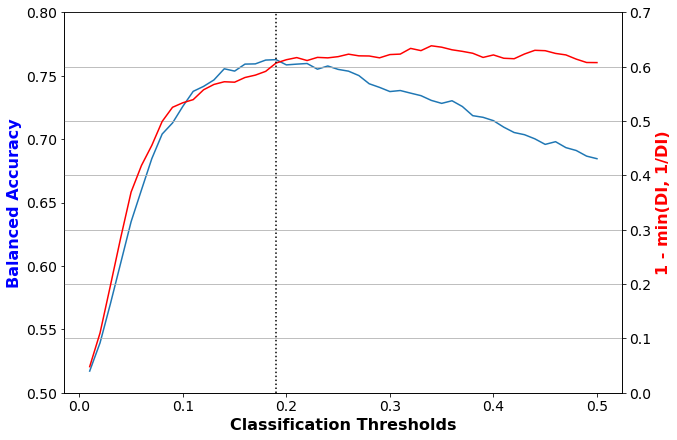

In [9]:

disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

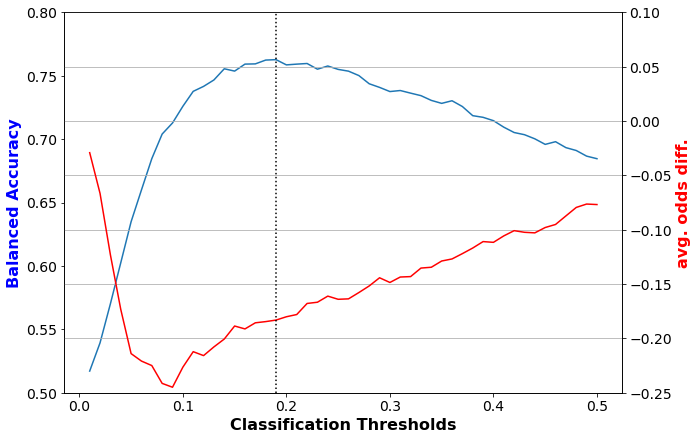

In [10]:
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

In [11]:
def describe_metrics(metrics, thresh_arr):
    best_ind = np.argmax(metrics['bal_acc'])
    print("Threshold corresponding to Best balanced accuracy: {:6.4f}".format(thresh_arr[best_ind]))
    print("Best balanced accuracy: {:6.4f}".format(metrics['bal_acc'][best_ind]))
#     disp_imp_at_best_ind = np.abs(1 - np.array(metrics['disp_imp']))[best_ind]
    disp_imp_at_best_ind = 1 - min(metrics['disp_imp'][best_ind], 1/metrics['disp_imp'][best_ind])
    print("Corresponding 1-min(DI, 1/DI) value: {:6.4f}".format(disp_imp_at_best_ind))
    print("Corresponding average odds difference value: {:6.4f}".format(metrics['avg_odds_diff'][best_ind]))
    print("Corresponding statistical parity difference value: {:6.4f}".format(metrics['stat_par_diff'][best_ind]))
    print("Corresponding equal opportunity difference value: {:6.4f}".format(metrics['eq_opp_diff'][best_ind]))
    print("Corresponding Theil index value: {:6.4f}".format(metrics['theil_ind'][best_ind]))


In [12]:

describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.1900
Best balanced accuracy: 0.7627
Corresponding 1-min(DI, 1/DI) value: 0.6066
Corresponding average odds difference value: -0.1831
Corresponding statistical parity difference value: -0.2643
Corresponding equal opportunity difference value: -0.1608
Corresponding Theil index value: 0.0936


In [13]:
lr_orig_metrics = test(dataset=dataset_test,
                       model=lr_orig_panel19,
                       thresh_arr=[thresh_arr[lr_orig_best_ind]])

In [14]:
describe_metrics(lr_orig_metrics, [thresh_arr[lr_orig_best_ind]])

Threshold corresponding to Best balanced accuracy: 0.1900
Best balanced accuracy: 0.7759
Corresponding 1-min(DI, 1/DI) value: 0.5738
Corresponding average odds difference value: -0.2057
Corresponding statistical parity difference value: -0.2612
Corresponding equal opportunity difference value: -0.2228
Corresponding Theil index value: 0.0921


In [15]:
model = PrejudiceRemover(sensitive_attr=sens_attr, eta=25.0)
pr_orig_scaler = StandardScaler()

dataset = dataset_train.copy()
dataset.features = pr_orig_scaler.fit_transform(dataset.features)

pr_orig_panel19 = model.fit(dataset)

In [16]:

thresh_arr = np.linspace(0.01, 0.50, 50)

dataset = dataset_val.copy()
dataset.features = pr_orig_scaler.transform(dataset.features)

val_metrics = test(dataset=dataset,
                   model=pr_orig_panel19,
                   thresh_arr=thresh_arr)
pr_orig_best_ind = np.argmax(val_metrics['bal_acc'])

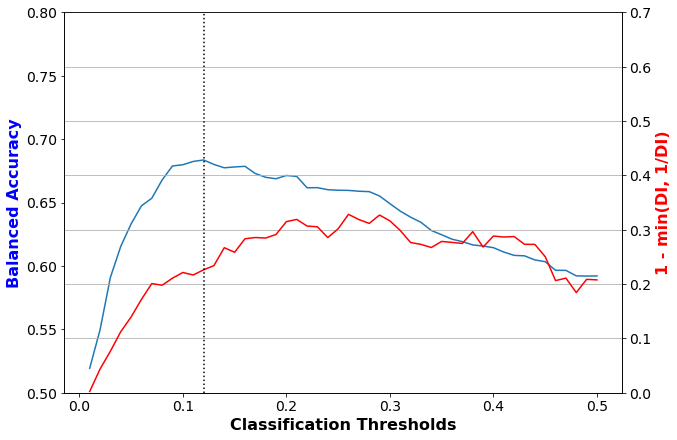

In [17]:

disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

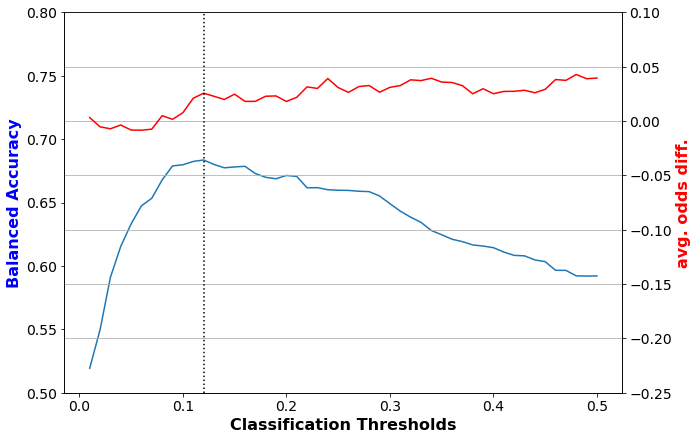

In [18]:

plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

In [19]:

describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.1200
Best balanced accuracy: 0.6836
Corresponding 1-min(DI, 1/DI) value: 0.2262
Corresponding average odds difference value: 0.0256
Corresponding statistical parity difference value: -0.0828
Corresponding equal opportunity difference value: 0.1172
Corresponding Theil index value: 0.1119


In [20]:
dataset = dataset_test.copy()
dataset.features = pr_orig_scaler.transform(dataset.features)

pr_orig_metrics = test(dataset=dataset,
                       model=pr_orig_panel19,
                       thresh_arr=[thresh_arr[pr_orig_best_ind]])

In [21]:
describe_metrics(pr_orig_metrics, [thresh_arr[pr_orig_best_ind]])


Threshold corresponding to Best balanced accuracy: 0.1200
Best balanced accuracy: 0.6880
Corresponding 1-min(DI, 1/DI) value: 0.1588
Corresponding average odds difference value: 0.0523
Corresponding statistical parity difference value: -0.0566
Corresponding equal opportunity difference value: 0.1479
Corresponding Theil index value: 0.1108


In [26]:
def forward(P):
    """
    Making Deep Neural Networks Robust to Label Noise: a Loss Correction Approach
    CVPR17 https://arxiv.org/abs/1609.03683
    :param P: noise model, a noisy label transition probability matrix
    :return:
    """
    P = K.constant(P)

    def loss(y_true, y_pred):
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
        return -K.sum(y_true * K.log(K.dot(y_pred, P)), axis=-1)

    return loss

class FairMLP(Transformer):

    def __init__(self, sensitive_attr=None,
                 privileged_demotion=0.1, privileged_promotion=0.01,
                 protected_demotion=0.01, protected_promotion=0.1,
                 hidden_sizes=[32, 64, 32],
                 num_epochs=10, batch_size=64):
        self.p_list = [np.array([[1 - privileged_demotion, privileged_demotion],
                                 [privileged_promotion, 1 - privileged_promotion]]),
                       np.array([[1 - protected_demotion, protected_demotion],
                                [protected_promotion, 1 - protected_promotion]])]
        self.model = None
        self.hidden_sizes = hidden_sizes
        self.input_shape = None
        self.num_classes = 2
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.sensitive_attr = sensitive_attr
        self.classes_ =  np.array([0, 1])

    def _compile_model(self):
        self.model = Sequential()
        self.model.add(InputLayer(input_shape=self.input_shape))
        self.model.add(Dropout(0.2))

        for hidden_size in self.hidden_sizes:
            self.model.add(Dense(hidden_size, activation='relu'))

        self.model.add(Dense(self.num_classes, activation="softmax"))
        self.model.compile(optimizer='adam',
                    loss=self._build_loss(),
                    metrics=[Accuracy(name="Acc")])



    def _build_loss(self):

        loss_list = []
        n_sensitive = len(self.p_list)
        for P in self.p_list:
            loss_list.append(forward(P))

        def combined_loss(y_true, y_pred):
            n_classes = y_true.shape[1] - n_sensitive
            y_true_sensitive = y_true[:,:n_sensitive]
            y_true = y_true[:,-n_classes:]
            l0 = loss_list[0](y_true, y_pred) * y_true_sensitive[:,0]
            l1 = loss_list[1](y_true, y_pred) * y_true_sensitive[:,1]

            return l0+l1

        return combined_loss

    def fit(self, dataset):
        if self.model is None:
            self.input_shape = dataset.features.shape[1]
            self._compile_model()

        if self.sensitive_attr is None or self.sensitive_attr == '':
            sensitive_index = 0
        else:
            sensitive_index = dataset.protected_attribute_names.index(self.sensitive_attr)

        X = dataset.features
        y_expanded = np.zeros( shape=(X.shape[0], 4) )

        y_expanded[:,0] = (dataset.protected_attributes[:,sensitive_index] != dataset.unprivileged_protected_attributes[sensitive_index]).astype(int)
        y_expanded[:,1] = (dataset.protected_attributes[:,sensitive_index] == dataset.unprivileged_protected_attributes[sensitive_index]).astype(int)
        y_expanded[:,2] = (dataset.labels == dataset.unfavorable_label).reshape(X.shape[0]).astype(int)
        y_expanded[:,3] = (dataset.labels == dataset.favorable_label).reshape(X.shape[0]).astype(int)

        self.model.summary()
        self.model.fit(X, y_expanded, epochs=self.num_epochs, batch_size=self.batch_size, verbose=True)

    def predict_proba(self, X):
        return self.model.predict(X)

    def predict(self, X):
        logits = self.predict_proba(X)
        return np.argmax(logits, axis=1)

In [27]:
describe(dataset_train, dataset_val, dataset_test)
dataset = dataset_train.copy()

#### Training Dataset shape

(7915, 138)


#### Validation Dataset shape

(4749, 138)


#### Test Dataset shape

(3166, 138)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['RACE']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names

['AGE', 'RACE', 'PCS42', 'MCS42', 'K6SUM42', 'REGION=1', 'REGION=2', 'REGION=3', 'REGION=4', 'SEX=1', 'SEX=2', 'MARRY=1', 'MARRY=2', 'MARRY=3', 'MARRY=4', 'MARRY=5', 'MARRY=6', 'MARRY=7', 'MARRY=8', 'MARRY=9', 'MARRY=10', 'FTSTU=-1', 'FTSTU=1', 'FTSTU=2', 'FTSTU=3', 'ACTDTY=1', 'ACTDTY=2', 'ACTDTY=3', 'ACTDTY=4', 'HONRDC=1', 'HONRDC=2', 'HONRDC=3', 'HONRDC=4', 'RTHLTH=-1', 'RTHLTH=1', 'RTHLTH=2', 'RTHLTH=3', 'RTHLTH=4', 'RTHLTH=5', 'MNHLTH=-1', 'MNHLTH=1', 'MNHLTH=2', 'MNHLTH=3', 'MNHLTH=4', 'MNHLTH=5', 'HIBPDX=-1', 'HIBPDX=1', 'HIBPDX=2', 'CHDDX=-1', 'CHDDX=1', 'CHDDX=2', 'ANGIDX=-1', 'ANGIDX=1', 'ANGIDX=2', 'MIDX=-1', 'MIDX=1', 'MIDX=2', 'OHRTDX=-1', 'OHRTDX=1', 'OHRTDX=2', 'STRKDX=-1', 'STRKDX=1', 'STRKDX=2', 'EMPHDX=-1', 'EMPHDX=1', 'EMPHDX=2', 'CHBRON=-1', 'CHBRON=1', 'CHBRON=2', 'CHOLDX=-1', 'CHOLDX=1', 'CHOLDX=2', 'CANCERDX=-1', 'CANCERDX=1', 'CANCERDX=2', 'DIABDX=-1', 'DIABDX=1', 'DIABDX=2', 'JTPAIN=-1', 'JTPAIN=1', 'JTPAIN=2', 'ARTHDX=-1', 'ARTHDX=1', 'ARTHDX=2', 'ARTHTYPE=-1'

In [28]:
params = {
  "protected_promotion": 0.03,
  "protected_demotion": 0.32,
  "privileged_promotion": 0.22,
  "privileged_demotion": 0.77}
fmlp = FairMLP(**params)

In [29]:
fmlp.fit(dataset)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_1 (Dropout)          (None, 138)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                4448      
_________________________________________________________________
dense_5 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 66        
Total params: 8,706
Trainable params: 8,706
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
124/124 [==============================] - 2s 3ms/step - loss: 0.7870 - Acc: 0.6993

In [31]:
thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=dataset_val,
                   model=fmlp,
                   thresh_arr=thresh_arr)

lr_orig_best_ind = np.argmax(val_metrics['bal_acc'])

describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.0100
Best balanced accuracy: 0.5000
Corresponding 1-min(DI, 1/DI) value:    nan
Corresponding average odds difference value: 0.0000
Corresponding statistical parity difference value: 0.0000
Corresponding equal opportunity difference value: 0.0000
Corresponding Theil index value: 0.1947


invalid value encountered in double_scalars


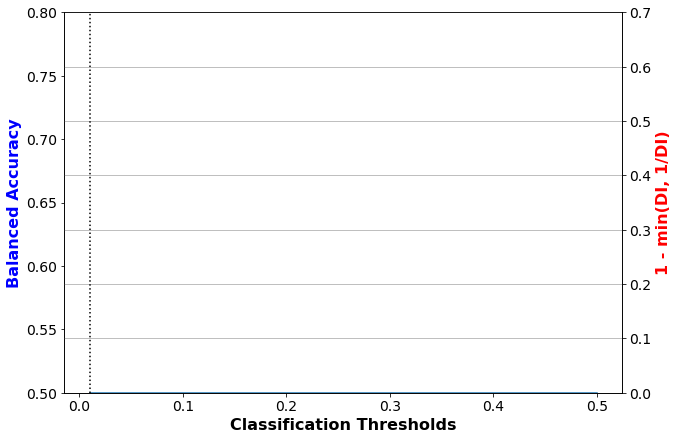

In [32]:
disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

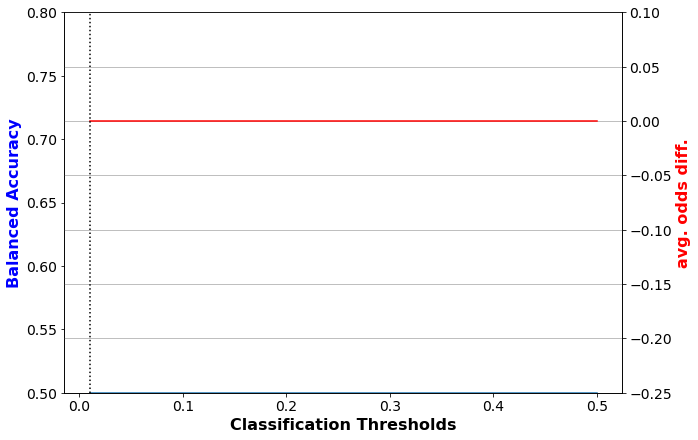

In [33]:
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')